In [1]:
from qat.core.qpu import QPUHandler
from qat.qpus import LinAlg
from qat.opt import MaxCut
from qat.plugins import ObservableSplitter, ScipyMinimizePlugin

import networkx
import numpy as np
import time
import matplotlib.pylab as plt

# Mixed precision

In this notebook, we show how the choice of precision in the GPU simulator can be exploited to obtain faster results in the context of variational algorithms. A straightforward way to obtain a speedup is to use single precision throughout the simulation. However, in certain applications we can not trade accuracy with simulation time. In such cases, we could use single precision for the first iterations and switch to double precision towards the end.

We can achieve it by designing a new QPU. To write any new QPU class compliant with QLM architecture, we need to: 
   - inherit from "QPUHandler" 
   - implement a "submit_job" method that takes a "job" and returns a "result"
  
The "MixedPrecisionQPU" below, has a counter to keep track of the iteration number and simply dispatches the jobs to appropriate QPU depending on some user defined threshold. 

In [2]:
class MixedPrecisionQPU(QPUHandler):## inherit from "QPUHandler" of qat.core
        
    def __init__(self, switch_precision): 
        self.qpu_float = LinAlg(use_GPU=True, precision=1)
        self.qpu_double = LinAlg(use_GPU=True, precision=2)
        self.switch_precision = switch_precision ## the iteration number where we switch from single to double precision
        self.counter = 0
        super(MixedPrecisionQPU, self).__init__()
        
    def submit_job(self, job):## implement a "submit_job" method
        self.counter += 1
        if self.counter < self.switch_precision:
            return self.qpu_float.submit_job(job)
        else:
            return self.qpu_double.submit_job(job)

Here we generate a random graph and solve the Maxcut problem on it using QAOA

In [3]:
def random_graph(n_edges, n_vertices):
    np.random.seed(20)
    graph = networkx.Graph()
    for i in range(n_edges):
        edge_0, edge_1 = np.random.choice(n_vertices, 2, replace=False)
        graph.add_edge(edge_0, edge_1)
    return graph    

Using the tools in qat.vsolve we can automatically convert the problem into a job with a parametrized circuit + an observable to optimize.

In [4]:
graph = random_graph(12, 24)
problem = MaxCut(graph)
job = problem.qaoa_ansatz(15, cnots=True)

In [5]:
print("maxcut with QAOA")
print("number of qubits: ", job.circuit.nbqbits)
print("number of gates in the ansatz: ", len(job.circuit.ops))
print("number of terms in the observable: ", len(job.observable.terms))

maxcut with QAOA
number of qubits:  24
number of gates in the ansatz:  924
number of terms in the observable:  12


In [6]:
max_iter = 300

# for a double precision simulation
stack_gpu = ScipyMinimizePlugin(method="COBYLA",
                                options={"maxiter":max_iter}) | LinAlg(use_GPU=True)

# we can stack the mixed precision QPU like any other QPU
# here we choose to perform the first 250 iterations in 
# single precision and the rest in double precision

stack_mixed_prec = ScipyMinimizePlugin(method="COBYLA",
                                       options={"maxiter":max_iter}) | MixedPrecisionQPU(250)

In [7]:
%%time
result = stack_gpu.submit(job)

CPU times: user 1min 34s, sys: 47.6 s, total: 2min 22s
Wall time: 2min 22s


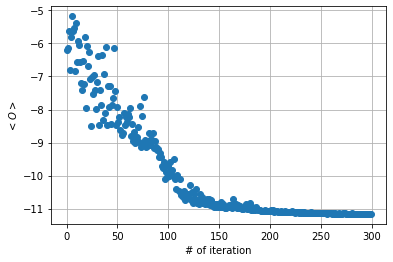

In [8]:
plt.figure()
plt.plot(eval(result.meta_data["optimization_trace"]), 'o')
plt.xlabel("# of iteration")
plt.ylabel("$<O>$")
plt.grid("both")

In [9]:
%%time
result = stack_mixed_prec.submit(job)

CPU times: user 59.6 s, sys: 28.6 s, total: 1min 28s
Wall time: 1min 28s


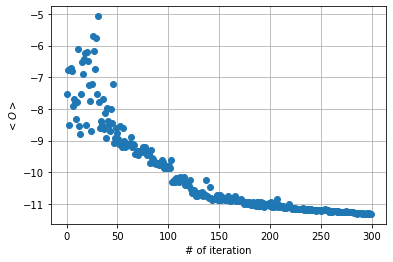

In [10]:
plt.figure()
plt.plot(eval(result.meta_data["optimization_trace"]), 'o')
plt.xlabel("# of iteration")
plt.ylabel("$<O>$")
plt.grid("both")

# Estimated simulation time on a CPU (2 sockets/32 cores)

Note: jupyter server used to run this notebook was launched with "numactl -l -N 4,5 jupyter-notebook ..."

In [11]:
## here we time 10 iterations by setting maxiter=10
stack_cpu = ScipyMinimizePlugin(method="COBYLA",
                                options={"maxiter":10}) | LinAlg()

In [12]:
%%time
result_cpu = stack_cpu.submit(job) 

CPU times: user 25min 3s, sys: 1.56 s, total: 25min 5s
Wall time: 23.7 s


a full simulation with 300 iterations would have taken 711 seconds on CPU against 142 seconds (x5) in double precision and 88 seconds (x8) using mixed precision on a GPU.